## Regressão linear de dados completos

Nesse notebook fazemos a regressão linear análoga à que tínhamos feitos com os dados de SP apenas, mas agora com os dados dos outros estados. 

O que é feito aqui pode ser dividido nos seguintes topicos:

- Abertura do dataset de doenças agrupadas
- Seleção das doenças com maior incidencia
- Realização de uma regressão linear que tem como `y` a prevalencia
- Analise do $ R^2 $ error das melhores regressões

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.decomposition import PCA

### A regressão

Aqui definimos a função que faz todos os modelos de regressçao linear e retorna as métricas que serão usadas para avaliar para quais doencas o modelo teve um bom desempenho.

In [2]:
def regressao(X, y):
    
    # separando conjunto de teste e treinamento
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    # regressão Linear 
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
        
    # erro r^2
    r2 = r2_score(y_test, y_pred)

    return r2, y_test, y_pred

## Desagrupados

In [3]:
desagrupados = pd.read_csv('../../../dados/formatado_agrupados.csv', sep = ';')
desagrupados.sample(5)

cod_muni  qtd_mora  incidencia diag_princ  prevalencia  \
81948     351570    168016         742        J18     0.004416   
126351    431162      5219           7        K59     0.001341   
47098     313820     91729          39        J06     0.000425   
119681    430580      9749          65        K80     0.006667   
69030     317107      5539           1        K51     0.000180   

        renda_media_mora  SITU1_entorno  SITU2_entorno  SITU3_entorno  \
81948           0.230396       0.957940        0.00000            0.0   
126351          0.318440       0.820160        0.00000            0.0   
47098           0.440695       0.904438        0.04942            0.0   
119681          0.309753       0.709994        0.00000            0.0   
69030           0.098043       0.695599        0.00000            0.0   

        SITU4_entorno  ...  V032_domicilio02  V033_domicilio02  \
81948        0.017982  ...          0.035305          0.003702   
126351       0.000000  ...          0.199158          0.001148   
47098        0.000000  ...          0.009154          0.036681   
119681       0.000000  ...          0.120898          0.128692   
69030        0.000000  ...          0.008830          0.283655   

        V034_domicilio02  V035_domicilio02  V036_domicilio02  \
81948           0.000202          0.003268          0.000547   
126351          0.006696          0.000000          0.000000   
47098           0.001703          0.003698          0.000054   
119681          0.031378          0.005127          0.000000   
69030           0.021265          0.039647          0.000000   

        V037_domicilio02  V038_domicilio02  V041_domicilio02  \
81948           0.001331          0.996893          0.001384   
126351          0.004209          0.997896          0.000574   
47098           0.003785          0.993829          0.001063   
119681          0.034557          0.995796          0.003897   
69030           0.000901          0.973689          0.024509   

        V045_domicilio02  V089_domicilio02  
81948           0.488057          0.511942  
126351          0.512531          0.487469  
47098           0.485043          0.514957  
119681          0.489746          0.510254  
69030           0.520995          0.479005  

[5 rows x 83 columns]

### Seleção de doenças

Primeiro fazemos uma seleção das doenças que fazem sentido serem analisadas, para isso usamos a lógica que uma doença com menos do que X casos não tem sentido ser analisada. 

No contexto específico, definimos uma variável "cutoff_incidencia" que define qual é o X para qual as doenças com menos casos do que esse número serão ignoradas

In [4]:
# acho que 10000 é um numero muito alto ainda
cutoff_incidencia = 10000

doencas_incidencia = desagrupados.groupby(['diag_princ']).sum()[['incidencia']]
doencas_incidencia.head(5)

incidencia
diag_princ            
J0                 142
J01               1754
J02                177
J03              15803
J04              27626

In [5]:
doencas_selected = doencas_incidencia[doencas_incidencia['incidencia'] >= cutoff_incidencia]
doencas_selected.head(5)

incidencia
diag_princ            
J03              15803
J04              27626
J06              40632
J10              13322
J11              37970

### Análise e resultados

Nesse bloco chamamos a função da regressão para as doenças selecionadas, fazendo a comparação entre uso ou não do PCA.

In [6]:
lista_doencas = doencas_selected.reset_index()['diag_princ'].unique()
lista_r2 = []
lista_y_test = []
lista_y_pred = []

for doenca in lista_doencas:
    df = desagrupados[desagrupados['diag_princ'] == doenca].copy()

    # Separando 
    y = df[['prevalencia']].to_numpy()
    X = df[df.columns[5:]].to_numpy()

    # Fazendo a principal component analysis
    pca = PCA(n_components=25)
    X_pca = pca.fit_transform(X)

    print('\n------- CID: ' + doenca)
    print('Quantidade de entradas: ' + str(y.shape[0]))
    print('Executando regressão linear')

    r2, y_test, y_pred = regressao(X_pca, y)    

    lista_r2.append(r2)
    lista_y_test.append(y_test)
    lista_y_pred.append(y_pred)

    print('Erro R^2: ' + str(r2))



------- CID: J03
Quantidade de entradas: 1334
Executando regressão linear
Erro R^2: 0.044213733809129074

------- CID: J04
Quantidade de entradas: 1566
Executando regressão linear
Erro R^2: 0.037365681659980776

------- CID: J06
Quantidade de entradas: 1806
Executando regressão linear
Erro R^2: -0.03478295282430177

------- CID: J10
Quantidade de entradas: 765
Executando regressão linear
Erro R^2: -0.29740253306731934

------- CID: J11
Quantidade de entradas: 1336
Executando regressão linear
Erro R^2: 0.02310404193960336

------- CID: J12
Quantidade de entradas: 1742
Executando regressão linear
Erro R^2: -0.022066188979377177

------- CID: J15
Quantidade de entradas: 2280
Executando regressão linear
Erro R^2: -0.007806751720396354

------- CID: J16
Quantidade de entradas: 593
Executando regressão linear
Erro R^2: 0.023634848650636697

------- CID: J18
Quantidade de entradas: 2407
Executando regressão linear
Erro R^2: 0.004645444356888184

------- CID: J21
Quantidade de entradas: 2109


## Melhores avaliações

Agora, vamos selecionar as 10 doenças com melhor erro $ R^2 $, ou seja, as doenças que nossa regressão linear melhor conseguiu estimar a prevalencia.

In [7]:
# ordenando as doencas pelo melhor (maior) erro
lista_r2, lista_doencas, lista_y_test, lista_y_pred = zip(*sorted(zip(np.negative(lista_r2), lista_doencas, lista_y_test, lista_y_pred)))
# pegando so os 10 primeiros
lista_r2, lista_doencas, lista_y_test, lista_y_pred = np.negative(lista_r2[:10]), lista_doencas[:10], lista_y_test[:10], lista_y_pred[:10]

lista_r2

array([0.26147941, 0.21121742, 0.19240379, 0.18728877, 0.1867117 ,
       0.16224853, 0.16039917, 0.13619883, 0.13293921, 0.12198777])

No handles with labels found to put in legend.


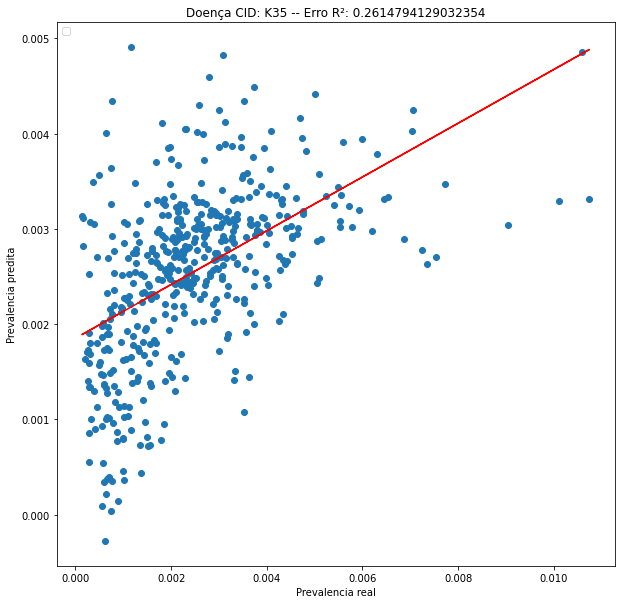

No handles with labels found to put in legend.


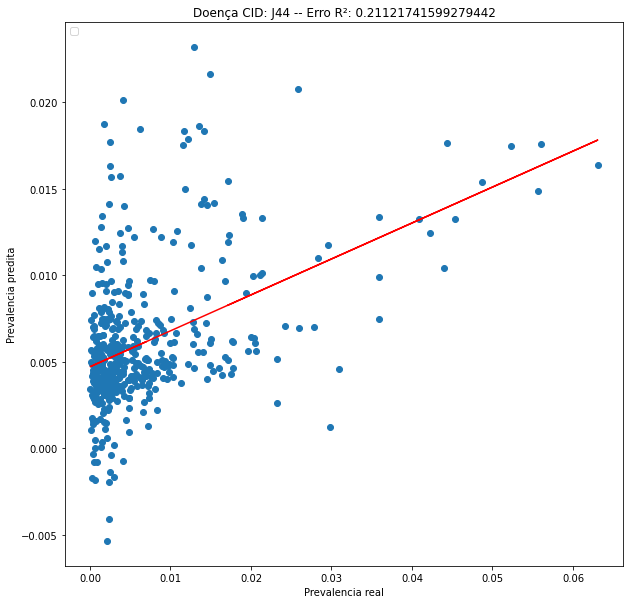

No handles with labels found to put in legend.


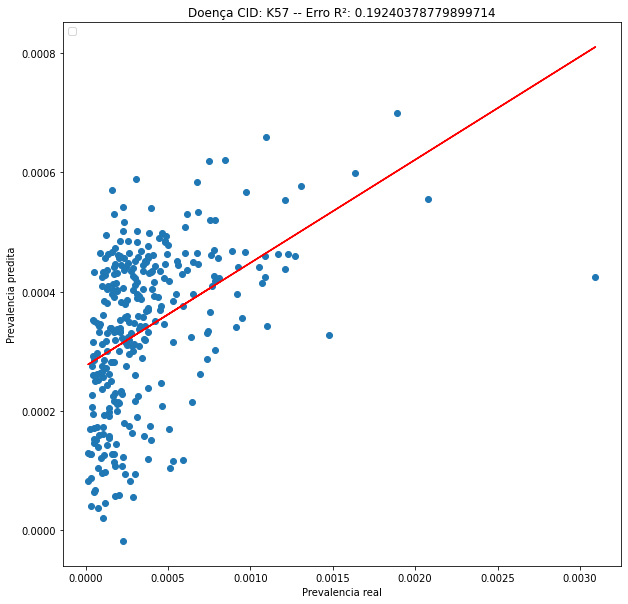

No handles with labels found to put in legend.


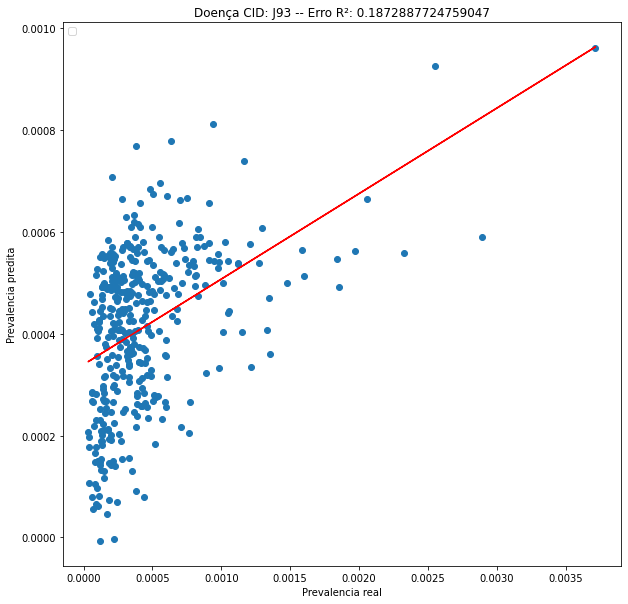

No handles with labels found to put in legend.


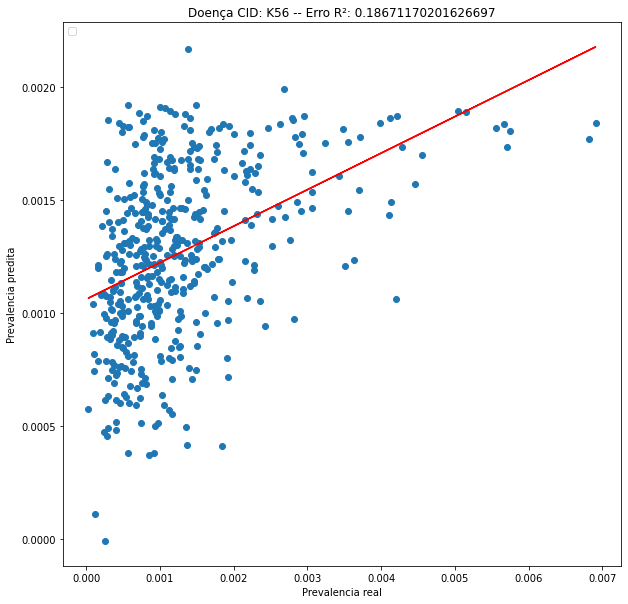

No handles with labels found to put in legend.


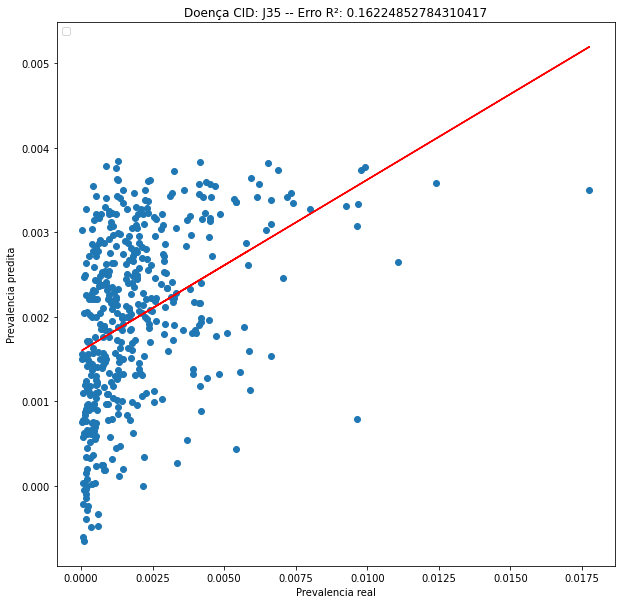

No handles with labels found to put in legend.


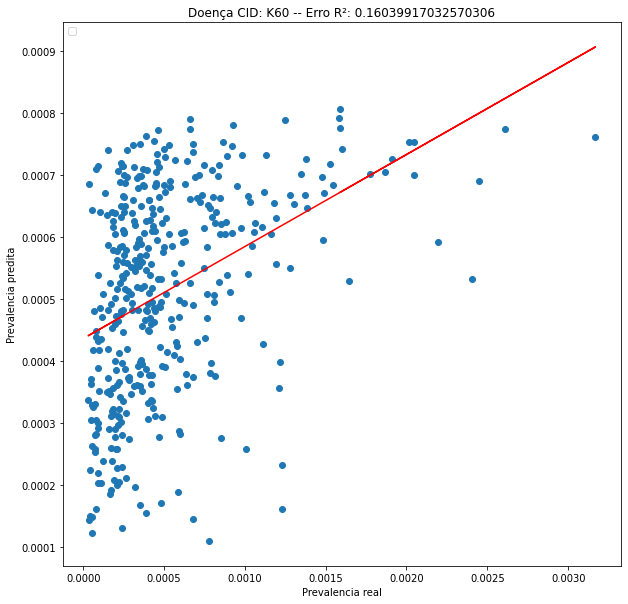

No handles with labels found to put in legend.


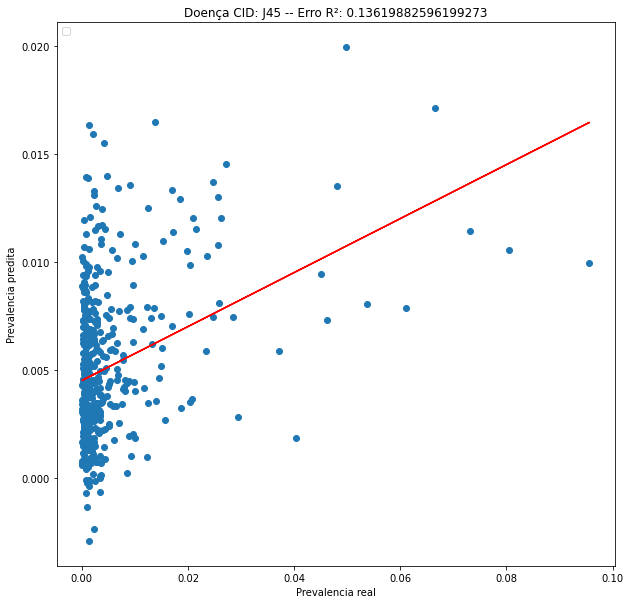

No handles with labels found to put in legend.


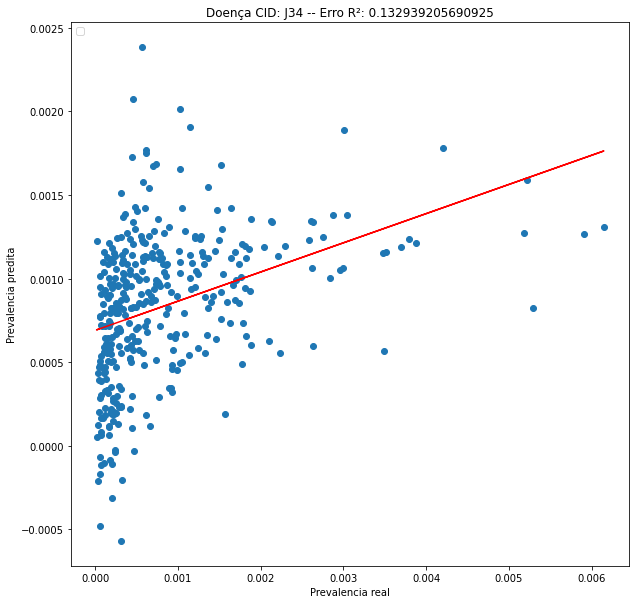

No handles with labels found to put in legend.


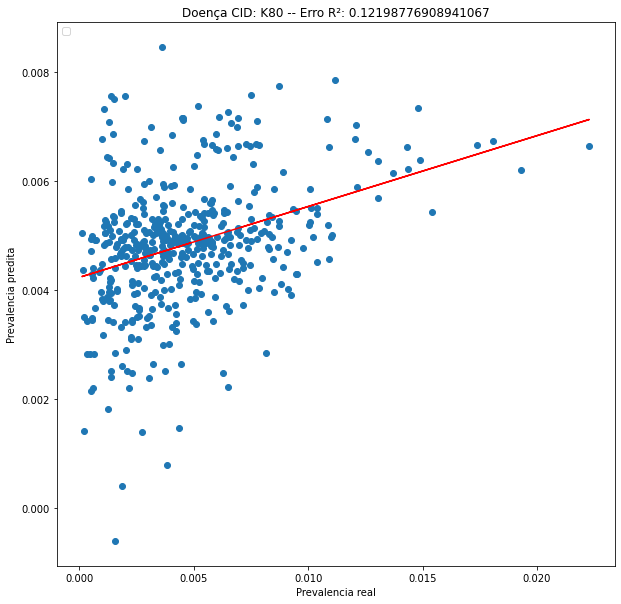

In [8]:
for doenca, erro, y_test, y_pred in zip(lista_doencas, lista_r2, lista_y_test, lista_y_pred):

    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111)

    ax1.scatter(y_test, y_pred)
    m, b = np.polyfit(np.squeeze(y_test), np.squeeze(y_pred), 1)
    plt.plot(y_test, m*y_test + b, color='red')

    plt.legend(loc='upper left')

    plt.xlabel('Prevalencia real')
    plt.ylabel('Prevalencia predita')
    plt.title('Doença CID: ' + doenca + ' -- Erro R²: ' + str(erro))
    plt.show()